In [1]:
# ========================================================
# Project: Titanic Survival Prediction (Advanced Models)
# Author: Karri Vamsi
# Date: July 27, 2025
# Description: Predict survival using KNN, Bagging+SGD, and Bagging+SVC.
# Dataset: Titanic_full.csv from Kaggle
# ========================================================

In [2]:
# Step 1: Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Step 2: Load and Prepare Titanic Dataset

# Load dataset
titanic_df = pd.read_csv('Titanic_full.csv')

# Stratified split
train_df, test_df = train_test_split(titanic_df, test_size=0.3, stratify=titanic_df['Survived'])

# Extract 'Title' from 'Name'
train_df['Title'] = train_df['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)

# Drop unused columns
columns_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId']
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

# Fill missing Age values and drop rows with other missing data
train_df.fillna({'Age': train_df['Age'].mean()}, inplace=True)
train_df.dropna(inplace=True)
test_df.fillna({'Age': train_df['Age'].mean()}, inplace=True)
test_df.dropna(inplace=True)

In [4]:
# Step 3: Prepare Features and Labels

# Split features and target
X_train_raw = train_df.drop(columns='Survived')
y_train = train_df['Survived']
X_test_raw = test_df.drop(columns='Survived')
y_test = test_df['Survived']

In [5]:
# Step 4: Preprocessing Pipeline (Encoding + Scaling)

# Create column transformer
preprocessor = ColumnTransformer([
    ('sex_encoder', OrdinalEncoder(categories=[['female', 'male']]), ['Sex']),
    ('embarked_encoder', OneHotEncoder(handle_unknown='ignore'), ['Embarked']),
    ('title_encoder', OneHotEncoder(handle_unknown='ignore'), ['Title'])
], remainder='passthrough')

# Build pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('scaling', MinMaxScaler())
])

# Fit-transform training and transform testing
X_train_transformed = pipeline.fit_transform(X_train_raw)
X_test_transformed = pipeline.transform(X_test_raw)

# Column names after transformation
embarked_features = preprocessor.named_transformers_['embarked_encoder'].get_feature_names_out(['Embarked']).tolist()
title_features = preprocessor.named_transformers_['title_encoder'].get_feature_names_out(['Title']).tolist()
final_features = ['Sex'] + embarked_features + title_features + [col for col in X_train_raw.columns if col not in ['Sex', 'Embarked', 'Title']]

# Convert to DataFrames
X_train = pd.DataFrame(X_train_transformed, columns=final_features, index=X_train_raw.index)
X_test = pd.DataFrame(X_test_transformed, columns=final_features, index=X_test_raw.index)


KNN best hyper parameters: {'weights': 'uniform', 'n_neighbors': 22, 'metric': 'manhattan', 'algorithm': 'auto'}
Best CV accuracy (KNN): 0.7239836666066175
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       241
           1       0.77      0.47      0.59       152

    accuracy                           0.74       393
   macro avg       0.75      0.69      0.70       393
weighted avg       0.75      0.74      0.72       393



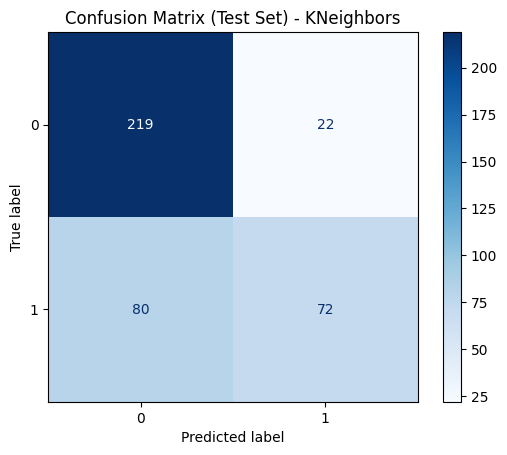

In [6]:
# Step 5: KNN Model with Hyperparameter Tuning

# Define hyperparameters
knn_param_grid = {
    'n_neighbors': list(range(3, 25)),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'algorithm': ['auto']
}

# RandomizedSearchCV for KNN
knn_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=knn_param_grid,
                                cv=5, n_iter=100, scoring='accuracy')
knn_best = knn_search.fit(X_train, y_train)

print("KNN best hyper parameters:",knn_search.best_params_)

# Best cross-validation score
print("Best CV accuracy (KNN):", knn_best.best_score_)

# Predict and evaluate
knn_predictions = knn_best.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, knn_predictions))

# Confusion matrix
cm_knn = confusion_matrix(y_test, knn_predictions)
ConfusionMatrixDisplay(cm_knn, display_labels=knn_best.classes_).plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set) - KNeighbors")
plt.show()


Train Accuracy (Bagging + SGD): 0.727547176882859
Validation Accuracy: 0.718507175884225
Bagging Classifier Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       241
           1       0.70      0.57      0.63       152

    accuracy                           0.74       393
   macro avg       0.73      0.71      0.71       393
weighted avg       0.73      0.74      0.73       393



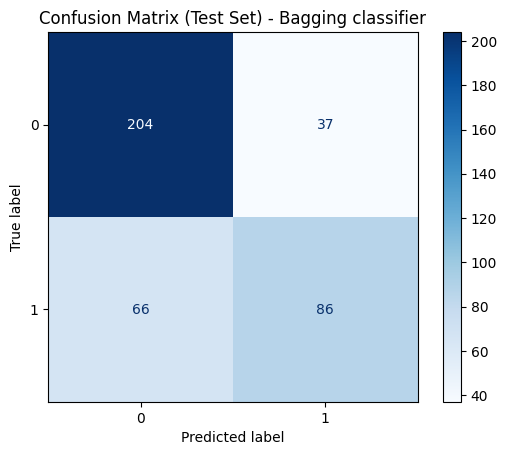

In [7]:
# Step 6: Bagging with SGDClassifier

# Build bagging model with SGDClassifier
bagging_model = BaggingClassifier(SGDClassifier(), n_estimators=250, max_samples=100, bootstrap=True, n_jobs=-1)
bagging_model.fit(X_train, y_train)

# Cross-validation scores
cv_scores = cross_validate(bagging_model, X_train, y_train, cv=5, scoring='accuracy', return_train_score=True)
print('Train Accuracy (Bagging + SGD):', cv_scores['train_score'].mean())
print('Validation Accuracy:', cv_scores['test_score'].mean())

# Predict and evaluate
bagging_predictions = bagging_model.predict(X_test)
print("Bagging Classifier Report:")
print(classification_report(y_test, bagging_predictions))

# Confusion matrix
cm_bag = confusion_matrix(y_test, bagging_predictions)
ConfusionMatrixDisplay(cm_bag, display_labels=bagging_model.classes_).plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set) - Bagging classifier")
plt.show()


Bagging classifier best hyper parameters: {'n_jobs': -1, 'n_estimators': 166, 'max_samples': 102, 'estimator': SVC(gamma=0.5), 'bootstrap': True}
Best CV accuracy (Bagging + SVC): 0.7086771152344922
Bagging + SVC Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       241
           1       0.77      0.45      0.57       152

    accuracy                           0.74       393
   macro avg       0.75      0.68      0.69       393
weighted avg       0.74      0.74      0.72       393



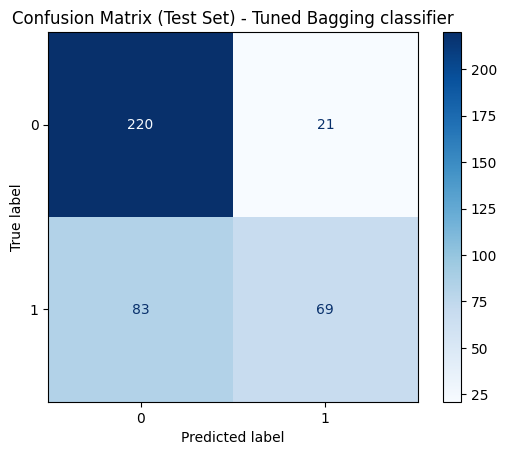

In [8]:
# Step 7: Bagging with SVC (Tuned)

# Define parameter grid with SVC inside Bagging
svc_bag_param_grid = {
    'estimator': [SVC(kernel='rbf', gamma=0.5)],
    'n_estimators': list(range(50, 300)),
    'max_samples': list(range(30, 120)),
    'bootstrap': [True, False],
    'n_jobs': [-1]
}

# RandomizedSearchCV for Bagging + SVC
svc_bag_search = RandomizedSearchCV(BaggingClassifier(), param_distributions=svc_bag_param_grid,
                                    cv=5, n_iter=100, scoring='accuracy')
svc_bag_best = svc_bag_search.fit(X_train, y_train)

print("Bagging classifier best hyper parameters:",svc_bag_search.best_params_)

# Best CV accuracy
print("Best CV accuracy (Bagging + SVC):", svc_bag_best.best_score_)

# Predict and evaluate
svc_bag_predictions = svc_bag_best.predict(X_test)
print("Bagging + SVC Classification Report:")
print(classification_report(y_test, svc_bag_predictions))

# Confusion matrix
cm_svc_bag = confusion_matrix(y_test, svc_bag_predictions)
ConfusionMatrixDisplay(cm_svc_bag, display_labels=svc_bag_best.classes_).plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set) - Tuned Bagging classifier")
plt.show()
